In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

In [23]:
import lmfit as lm
from dat_analysis.analysis_tools import nrg
from dat_analysis.useful_functions import get_data_index 
from dat_analysis.plotting.mpl.util import make_axes, xyz_to_explicit_meshgrid, addcolorlegend
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.interpolate import interp1d
import datetime
import copy
import os
from itertools import chain

fig_dir = 'kondo_conductance_fiures/'
os.makedirs(fig_dir, exist_ok=True)

In [3]:
%matplotlib inline
mpl.rcParams.update({
    'figure.figsize': (6.4,4.8),
    'figure.dpi': 110,  # 27in 1440p = 110
})
print(f'Notebook last run on {datetime.date.today()}')

Notebook last run on 2022-05-18


# Introduction

Figuring out whether we can use a similar to existing device design in order to measure expected kondo effects by conductance measurements in a similar regime (i.e. similar $\Gamma$) to where we can do $dN/dT$ measurements. 

Currently, $dT/dT$ measurements do not show the expected shift of entropy towards the occupied state of the QD that NRG predicts, and it is unclear as to the reason for this. 

The common measurement of Kondo effect and temperature is a conductance measurement with much larger $\Gamma$ than we can achieve with entropy measurements. So, the aim for this device is to bridge the gap. 

First, we want to be able to do conductance measurements in the very large $\Gamma >> T$ limit, very similar to several measurements by other groups. This will allow us to check the effect the charge sensor has on conductance measurements in a limit where we should defitely be able to observe the usual signs of Kondo effect. This should be relatively easy to achieve in an QD with coupling to two reservoirs, and is therefore not a focus of this document.

Second, we want to be able to compare conductance measurements of the system with $\Gamma \sim 20 T$ to NRG calculated conductance in the same regime. So far we have only compared $dN/dT$ measurements and do not understand the discrepancy. Comparing conductance measurements in the same regime will give more information. Additionally, the conductance measurements may allow for a separate determination of $T_K$ in this regime. Figuring out what we might be able to see in this regime is the focus of this document.

# Loading Data

Loading the older NRG data with fixed $\Gamma = 0.001$ and varying $T$. 

In [4]:
nrg_data = nrg.NRGData.from_old_mat()
print(f'nrg_data keys are {nrg_data.__dict__.keys()}')
print(f'All Gs == 0.001 in this nrg_data ({np.all([g == 0.001 for g in nrg_data.gs])})')
gamma = nrg_data.gs[0]
print(f'Ens are the same for every row of nrg_data ({np.all(np.all([ens == nrg_data.ens[0] for ens in nrg_data.ens]))})')

nrg_data keys are dict_keys(['ens', 'ts', 'conductance', 'dndt', 'entropy', 'occupation', 'int_dndt', 'gs'])
All Gs == 0.001 in this nrg_data (True)
Ens are the same for every row of nrg_data (True)


C:\Users\Child\AppData\Local\Temp/ipykernel_13280/4062176288.py:1: DeprecatedWarning:

from_old_mat is deprecated. Use "from_new_mat" instead



Just loading the data that was sent in a .mat file. 
Note that the ens are a 2D array where each row is the same. Later I will shift each such that $N=0.5$ at $x=0$ as this is comparable to experiment

Also, the Gs are a 1D array, but every value is 0.001 because this data was calculated with fixed Γ
varying 𝑇 where the newer data is the opposite.

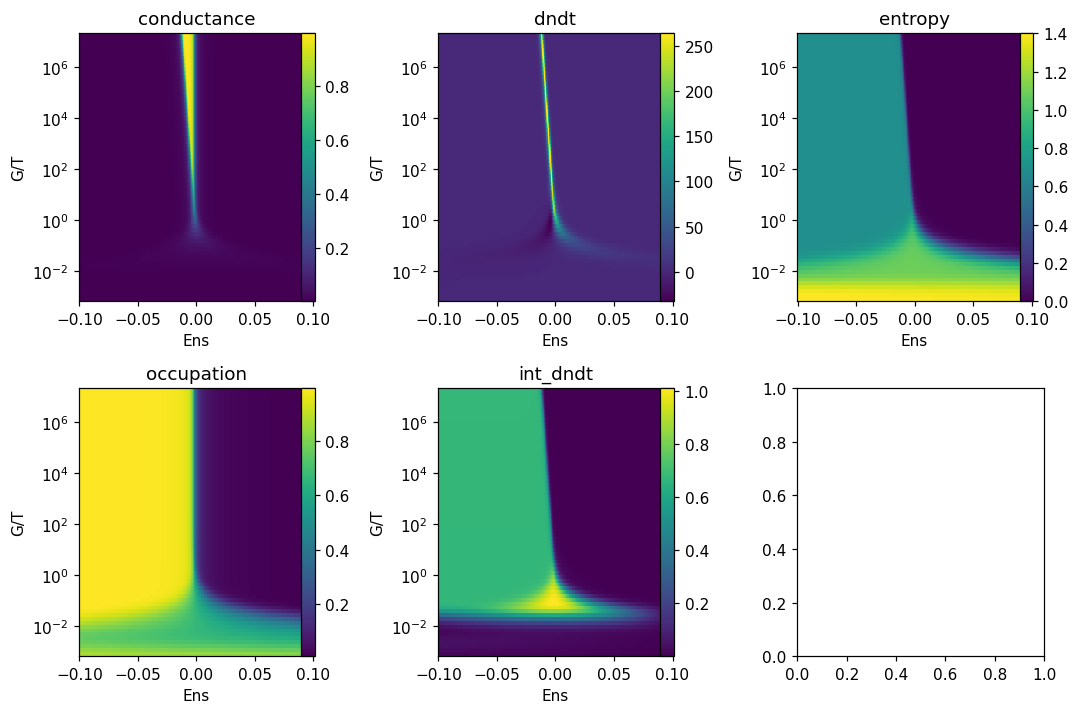

In [5]:
keys_2d = ['conductance', 'dndt', 'entropy', 'occupation', 'int_dndt']

fig, axs = make_axes(len(keys_2d))

for key, ax in zip(keys_2d, axs):
    x = nrg_data.ens[0]
    y = nrg_data.gs/nrg_data.ts
    data = nrg_data.__getattribute__(key)
    ax.pcolormesh(x, y, data, shading='auto')#, vmin=0, vmax=1.4)
    addcolorlegend(ax)
    ax.set_yscale('log')#     display_2d(x, y, data.__getattribute__(key), ax, colorscale=True, x_label='Ens', y_label='G/T')
    ax.set_xlabel('Ens')
    ax.set_ylabel('G/T')
    ax.set_title(key)
fig.tight_layout()

Note that `entropy` and `int_dndt` only look different because of the colorscales. With the same range, they look identical (excluding the region where the transition is cutoff)

# Region of interest

The NRG data extends to much higher $\Gamma/T$ than we are interested in for these crossover between entropy and conductance measurements. We are limited to work in a regime with $\Gamma < 30 k_B T$. 

In [6]:
gts = nrg_data.gs/nrg_data.ts
indexes = get_data_index(gts, [40, 0.5])  
s_ = np.s_[indexes[0]:indexes[1]]
print(f'We are mostly interested in data between rows {indexes} (G/T = {gts[indexes[0]]:.3g} to {gts[indexes[1]]:.3g})')

x_indexes = get_data_index(nrg_data.ens[0], [.025, -0.025])
xs_ = np.s_[x_indexes[0]:x_indexes[1]]
print(f'The corresponding ens range which is useful is from indexes {x_indexes} (ens = {nrg_data.ens[0][x_indexes[0]]:.3g} to {nrg_data.ens[0][x_indexes[1]]:.3g})')

We are mostly interested in data between rows [38 50] (G/T = 37.1 to 0.579)
The corresponding ens range which is useful is from indexes [150 250] (ens = 0.025 to -0.025)


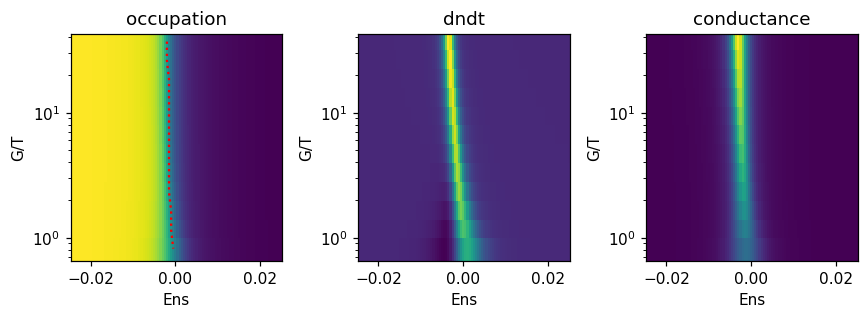

In [7]:
keys = ['occupation', 'dndt', 'conductance']
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs = axs.flatten()

for key, ax in zip(keys, axs):
    x = nrg_data.ens[0][xs_]
    y = gts[s_]
    data = nrg_data.__getattribute__(key)[s_,xs_]
    ax.pcolormesh(x, y, data, shading='auto')
    
    if key == 'occupation':
        x_nhalfs = [x[get_data_index(d, 0.5)] for d in data]
        ax.plot(x_nhalfs, y, 'r:')
    
    ax.set_yscale('log')
    ax.set_xlabel('Ens')
    ax.set_ylabel('G/T')
    ax.set_title(key)
fig.tight_layout()


For experimental data, the absolute 0 of the Ens axis above cannot be determined. Instead it is helpful to set $x=0$ where $N=0.5$. The dotted red line in the Occupation data above shows the $N=0.5$ locations.

# Redefine $x=0$ at $N=0.5$

To make the data more comparable to measurement, where theh absolute energy is not known but the occupation can be measured. We want to redefine the $x=0$ to be where $N=0.5$

In [15]:
occ = nrg_data.occupation[s_,xs_]
dndt = nrg_data.dndt[s_,xs_]
cond = nrg_data.conductance[s_,xs_]
nrg_ens = nrg_data.ens[s_, xs_]

# Use interpolation to find the x_half value then shift ens by that value
x_ns = []
for ens, d in zip(nrg_ens, occ):
    interper = interp1d(d, ens, kind='linear')
    x_half = interper(0.5)
    x_ns.append(ens-x_half)
    
ts = nrg_data.ts[s_]
gs = nrg_data.gs[s_]
gts = gs/ts
x_ns = np.array(x_ns)
datas = [occ, dndt, cond]
names = ['Occupation', 'dNdT', 'Conductance']

Now we have a 2D `x_ns` array which contains an energy x-axis for each row of NRG data where $x=0 <=> N=0.5$.
Arrays which only contain the region of interest are:
- `ts` -- 1D temperatures
- `gs` -- 1D Gammas (all 0.001)
- `gts` -- 1D Gamma/T ratios
- `nrg_ens` -- 2D Original NRG energy axis
- `x_ns` -- 2D Energy axis
- `occ` -- 2D Occupation
- `dndt` -- 2D dNdT
- `cond` -- 2D Conductance

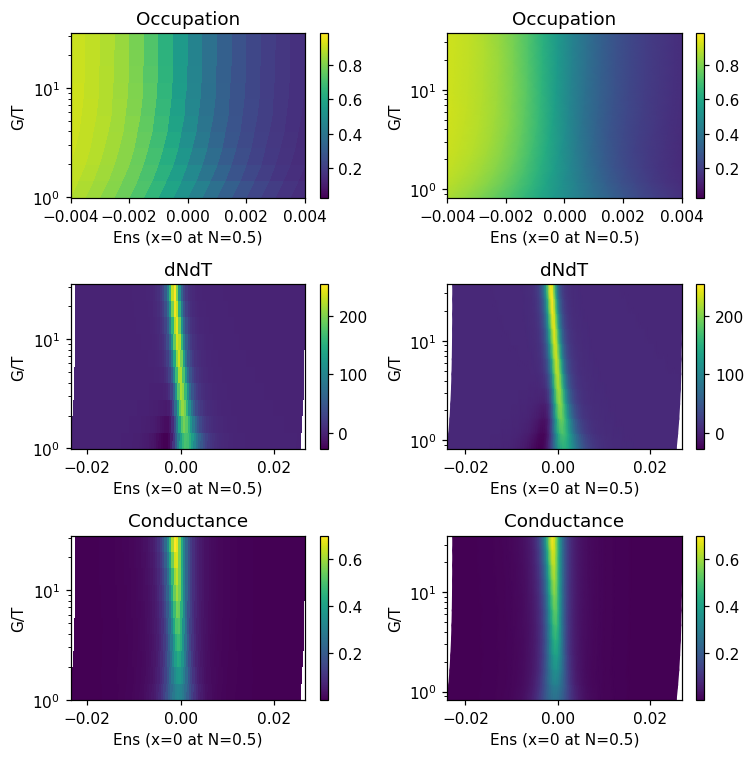

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))

for i, (data, name) in enumerate(zip(datas, names)):
    ax = axs[i, 1]
    ax2 = axs[i, 0]
    x = x_ns
    y = gts
    xx, yy, zz = xyz_to_explicit_meshgrid(x, y, data)
#     pcm = ax.pcolormesh(x[1:-1,1:-1], y[1:-1], data[1:-1,1:-1], shading='nearest')
    pcm = ax.pcolormesh(x, y, data, shading='gouraud')
    pcm = ax2.pcolormesh(xx, yy, zz)
    
    if np.all(data == occ):
        x_nhalfs = [x[i][get_data_index(d, 0.5)] for i, d in enumerate(data)]
        ax.set_xlim(-0.004, 0.004)
        ax2.set_xlim(-0.004, 0.004)
    for a in [ax, ax2]:
        fig.colorbar(pcm, ax=a)
        a.set_yscale('log')
        a.set_xlabel('Ens (x=0 at N=0.5)')
        a.set_ylabel('G/T')
        a.set_title(name)
fig.tight_layout()

Left/Right show the same data with different plotted slightly differently. Also note, the Occupation data is zoomed in close to $x=0$.

Left: quadrilaterals shaded around each datapoint where quadrilateral corners are interpolated half way between original coordinates (my own function which avoids ANY extrapolation of axes by dropping the data around the edge followed by 2D interpolation of x and y axes expressed as 2D arrays. Ends up being almost equivalent to 'nearest' plotting, but I wanted to be sure) -- Generally, this should be the safest way to plot data.

Right: "gouraud" shading using exact coordinates of datapoints and linear interpolation between them (built-in mpl function) -- Generally riskier way to plot data because it's hard to tell what gaps the interpolation is filling in.

I show both plots because the conductance plot with quadrilaterals shaded is misleading in appearance. It *looks* as though the $N=0.5$ of occupation is not located at $x=0$ despite the data being shifted precicely to achieve that. I believe the discrepancy is an optical illusion caused by the now non-rectangular grid that is a result of shifting the x-axis of each row independently. 

When plotted with interpolation (right), there apparent discrepancy becomes much less obvious, since this also more closely matches the way the data is centred (i.e. that the place where the occupation would actually pass through $N=0.5$ is shifted to zero, rather than just the closest existing datapoint)

# Simulate possible measurements

Now we can use this data to simulate what we would be able to measure, and use the simulated results to determine whether there will likely be enough information to detect a discrepancies between measurement and NRG calculation. For example, between conductance measurements and NRG calculated conductance.

In real measurements of conductance, we can additionally turn on/off the charge sensor to see if back-action has any effect on that at least. 

In [17]:
# Ratios to show in following plots
gt_ratios = [0.5, 1, 3, 7, 15, 30]

## Conductance and N for varying $\Gamma$
These are the new measurements we will make to hopefully resolve whether NRG does in fact match conductance measurements and *only* shows a discrepancy in entropy (this would be the most interesting case), or whether we also do not see a shift in conductance where NRG predicts (may still be interesting in showing that NRG does not predict mixed valence regime well). 

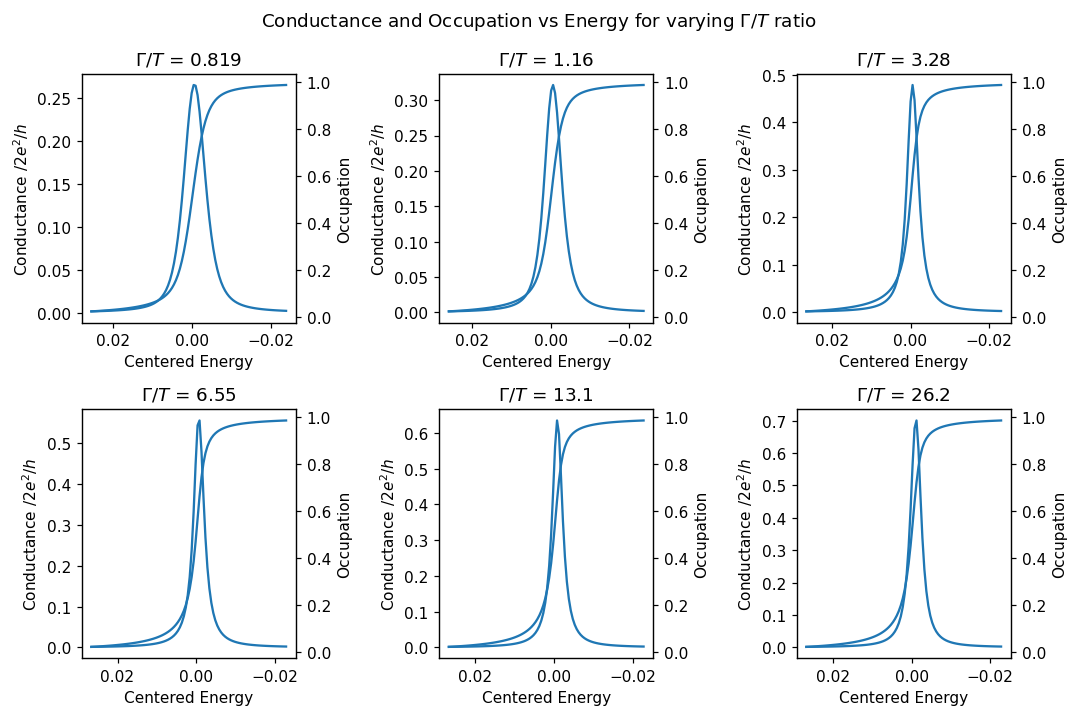

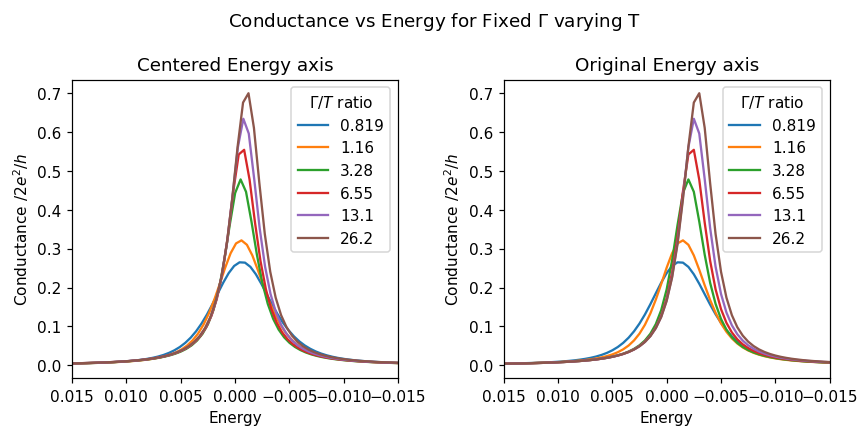

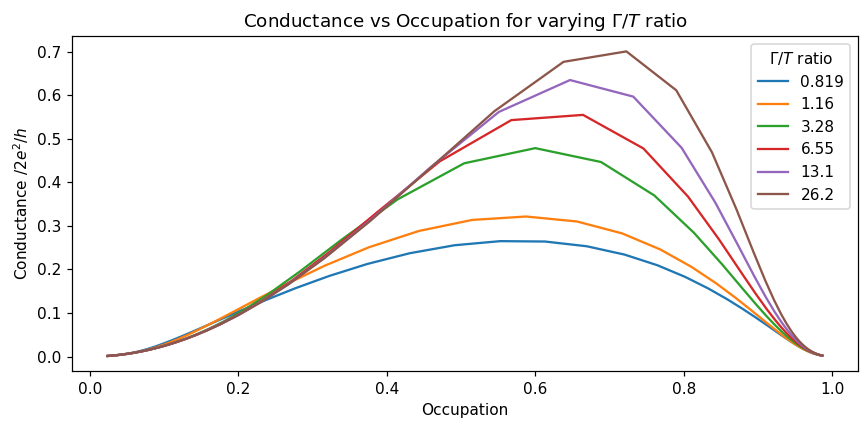

In [24]:
fig1, ax1s = make_axes(len(gt_ratios))
fig1b, ax1bs = plt.subplots(1, 2, figsize=(8, 4))
fig2, ax2 = plt.subplots(1, figsize=(8, 4))

fig1.suptitle('Conductance and Occupation vs Energy for varying $\Gamma/T$ ratio')
for ax in ax1s:
    ax.set_xlabel('Centered Energy')
    ax.set_ylabel('Conductance /$2e^2/h$')

fig1b.suptitle(f'Conductance vs Energy for Fixed $\Gamma$ varying T')
ax1bs[0].set_title(f'Centered Energy axis')
ax1bs[1].set_title(f'Original Energy axis')
for ax in ax1bs:
    ax.set_xlabel(f'Energy')
    ax.set_ylabel(f'Conductance /$2e^2/h$')
    ax.set_xlim(-0.015, 0.015)

ax2.set_title(f'Conductance vs Occupation for varying $\Gamma/T$ ratio')
ax2.set_xlabel('Occupation')
ax2.set_ylabel('Conductance /$2e^2/h$')

for i, gt in enumerate(gt_ratios):
    index = get_data_index(gts, gt)
    gt = gts[index]
    T = ts[index]
    G = gs[index]
    x = x_ns[index]
    ens = nrg_ens[index]
    data_cond = cond[index]
    data_occ = occ[index]
    # x = np.flip(x_ns[index], axis=-1)
    # data_cond = np.flip(cond[index], axis=-1)
    # data_occ = np.flip(occ[index], axis=-1)
    
    ax1s[i].plot(x, data_cond)
    twin_ax = ax1s[i].twinx()
    twin_ax.plot(x, data_occ)
    ax1s[i].set_title(f'$\Gamma/T$ = {gt:.3g}')
    twin_ax.set_ylabel('Occupation')

    # ax1bs[0].plot(x*T/G, data_cond, label=f'{gt:.3g}')
    ax1bs[0].plot(x, data_cond, label=f'{gt:.3g}')
    # ax1bs[1].plot(nrg_data.ens[0, xs_]*T/G, data_cond, label=f'{gt:.3g}')
    ax1bs[1].plot(ens, data_cond, label=f'{gt:.3g}')

    ax2.plot(data_occ, data_cond, label=f'{gt:.3g}')
    
for ax in chain(ax1bs, ax1s):
    ax.invert_xaxis()  # Note: Inverts for the twin_ax as well -- This is to put Occ = 1 on RHS

ax2.legend(title='$\Gamma/T$ ratio')

for ax in ax1bs:
    ax.legend(title='$\Gamma/T$ ratio')
    
fig1.tight_layout()
fig1b.tight_layout()
fig2.tight_layout()

fig1b.savefig(fig_dir+'conductance_vs_energy.png')
fig2.savefig(fig_dir+'conductance_vs_occupation.png')

Showing Conductance vs Energy for both centered energy and original energy axis as I'm not sure which is actually a better comparison to experiment, specifically DGGs measurements. I.e. I'm not sure if DGGs measurements are such that their dashed line for the peak represents $N=0.5$ or a fixed $V_g$ that was $N=0.5$ at one $T$ only. 

Probably safer to look at Conductance vs Occupation where it doesn't matter how the energy axis is defined.

This shift seen in Conductance vs Occupation is very similar to the predicted $dN/dT$ shift. So it will be interesting to see if we measure this conductance shift.  

## $dN/dT$ and N for varying $\Gamma$
This is the normal measurement we make where we see $dN/dT$ centered at $N=0.5$ regardless of Gamma where NRG shows a signficant shift. 

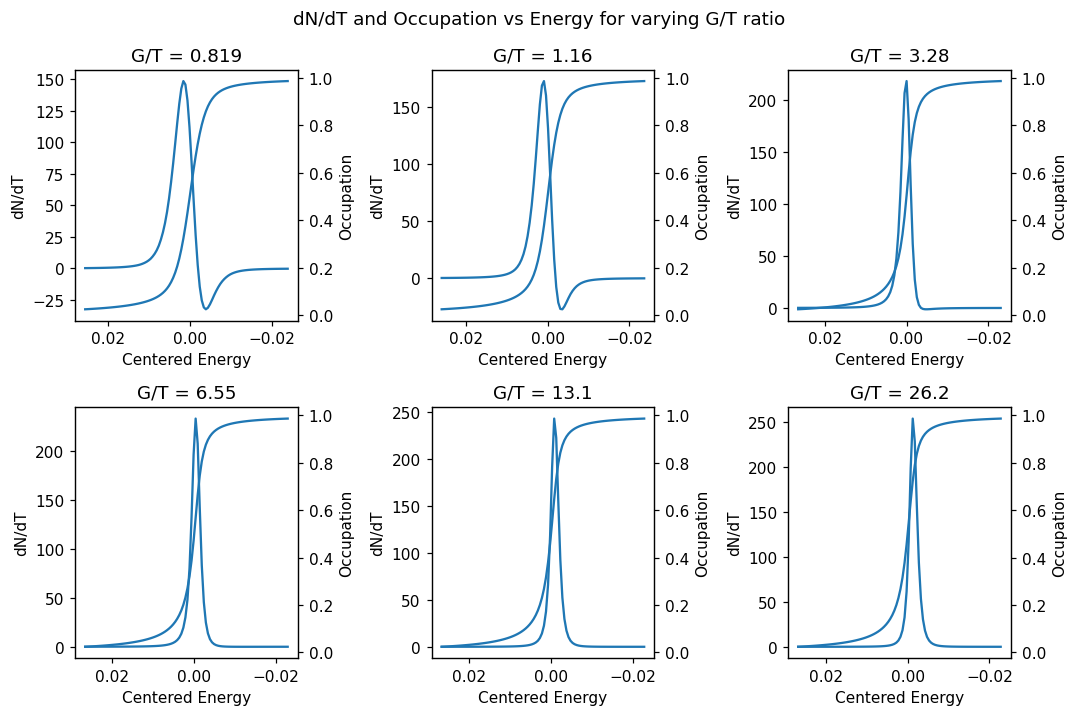

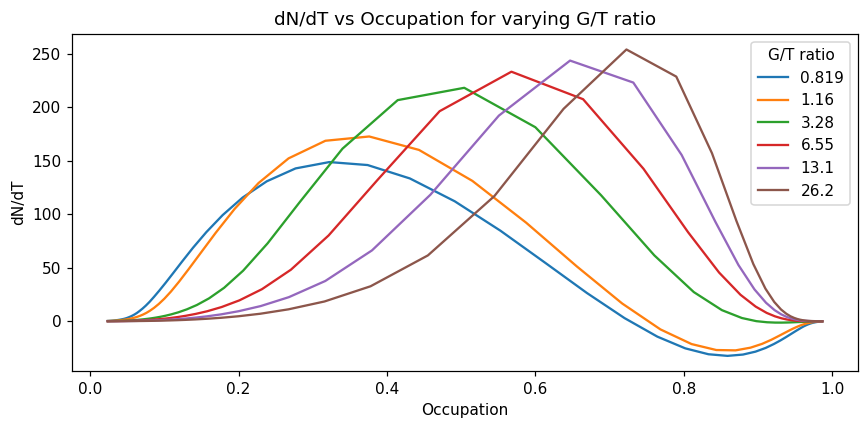

In [26]:
fig1, ax1s = make_axes(len(gt_ratios))
fig2, ax2 = plt.subplots(1, figsize=(8,4))
fig1.suptitle('dN/dT and Occupation vs Energy for varying G/T ratio')    

ax2.set_title(f'dN/dT vs Occupation for varying G/T ratio')
ax2.set_xlabel('Occupation')
ax2.set_ylabel('dN/dT')

for i, gt in enumerate(gt_ratios):
    index = get_data_index(gts, gt)
    gt = gts[index]
    x = x_ns[index]
    data_dndt = dndt[index]
    data_occ = occ[index]
    
    ax1s[i].plot(x, data_dndt)
    twin_ax = ax1s[i].twinx()
    twin_ax.plot(x, data_occ)
    ax1s[i].set_title(f'G/T = {gt:.3g}')
    ax1s[i].set_xlabel('Centered Energy')
    ax1s[i].set_ylabel('dN/dT')
    twin_ax.set_ylabel('Occupation')
    
    ax2.plot(data_occ, data_dndt, label=f'{gt:.3g}')

for ax in ax1s:
    ax.invert_xaxis()  # Note: Inverts for the twin_ax as well -- This is to put Occ = 1 on RHS

ax2.legend(title='G/T ratio')
fig1.tight_layout()
fig2.tight_layout()
fig2.savefig(fig_dir+'dndt_vs_occupation.png')

## Conductance at fixed N/Energy for varying $T$
This will hopefully allow us to determine $T_K$ through conventional methods, although the risk is that we are in a too low $\Gamma$ regime compared to conventional measurements to do this.
If we can measure $T_K$ like this, it will confirm whether we should be seeing the Kondo effect in other measurements.
We could repeat this with the CS on/off and see if $T_K$ changes (this might not be a meaningful question).

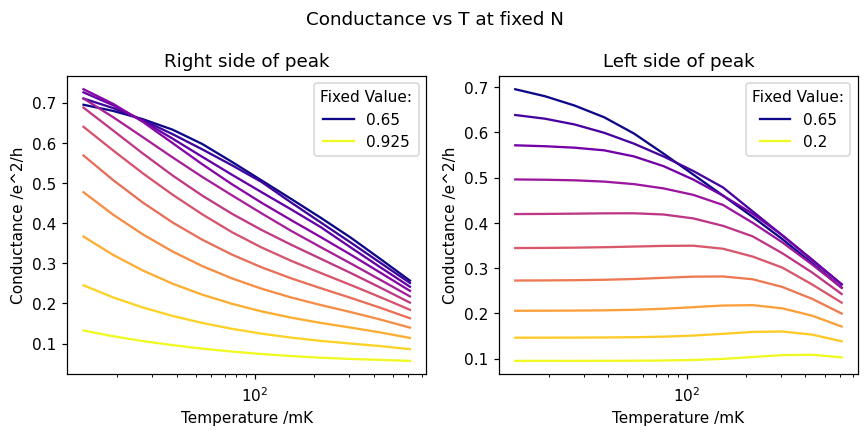

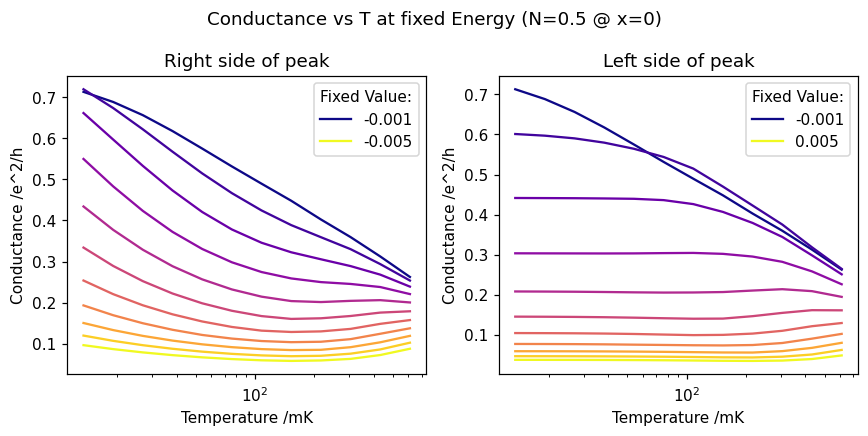

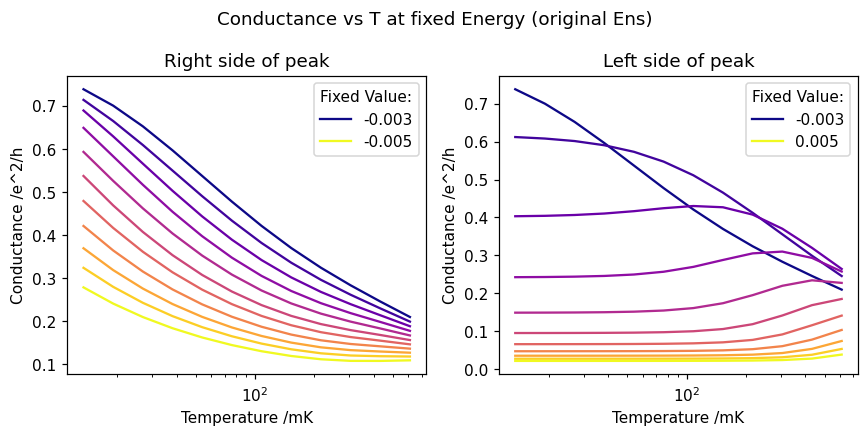

In [36]:
def get_cond_vs_T(x_axis, cond, x_value: float) -> np.ndarray:
    """Return conductance at an x-axis value"""
    x_axis = np.atleast_2d(x_axis)
    cond = np.atleast_2d(cond)
    
    cond_vs_t = []
    for j, row in enumerate(x_axis):
        cond_vs_t.append(interp1d(row, cond[j])(x_value))  # Get conductance where x_axis = value
    return np.array(cond_vs_t).squeeze()

fixed_g = 2  # G in Kelvin  (to make scales easier to compare to measurement)
fixed_Ns_right = np.arange(0.65, 0.95, 0.025)
fixed_Ns_left = np.arange(0.65, 0.15, -0.05)

fixed_centered_ens_right = np.linspace(-0.001, -0.005, 11)
fixed_centered_ens_left = np.linspace(-0.001, 0.005, 11)

fixed_ens_right = np.linspace(-0.0030, -0.005, 11)
fixed_ens_left = np.linspace(-0.0030, 0.005, 11)

fixed_lefts = [fixed_Ns_left, fixed_centered_ens_left, fixed_ens_left]
fixed_rights = [fixed_Ns_right, fixed_centered_ens_right, fixed_ens_right]
x_axes = [occ, x_ns, nrg_ens]

all_axs = [] 
figs = []
for _ in range(3):
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    figs.append(fig)
    all_axs.append(axs)
all_axs = np.array(all_axs)

# figs, all_axs = plt.subplots(3, 2, figsize=(8,4))
figs[0].suptitle('Conductance vs T at fixed N')
figs[1].suptitle('Conductance vs T at fixed Energy (N=0.5 @ x=0)')
figs[2].suptitle('Conductance vs T at fixed Energy (original Ens)')
for ax in all_axs[:, 0]:
    ax.set_title(f'Right side of peak')
for ax in all_axs[:, 1]:
    ax.set_title(f'Left side of peak')
for ax in all_axs.flatten():
    ax.set_xlabel('Temperature /mK')
    ax.set_ylabel('Conductance /e^2/h')
    ax.set_xscale('log')
    
for k, axs in enumerate(all_axs):
    rights = fixed_rights[k]
    lefts = fixed_lefts[k]
    x_axis = x_axes[k]
    for j, fixed_values in enumerate([rights, lefts]):
        colors = plt.cm.plasma(np.linspace(0, 1, len(fixed_values)))
        ax = axs[j]
        
        for i, value in enumerate(fixed_values):
            cond_vs_T = get_cond_vs_T(x_axis, cond, value)
            leg_prefix = '' if i == 0 or i == len(fixed_values)-1 else '_'  # Only show first and last in legend
            ax.plot(ts*1000/(fixed_g*0.001), cond_vs_T, color=colors[i], label=f'{leg_prefix}{value:.3g}') # , marker='x')

for ax in all_axs.flatten():
    ax.legend(title='Fixed Value:')
        
for fig in figs:
    fig.tight_layout()
   

Top figure is intended to replicate DGG Fig 4. Definitely shares some similarities.
Here we never see the conductance increasing for large N high T, but maybe because we aren't going to high enough T here. Let's see if we can extract $T_K$ anyway.

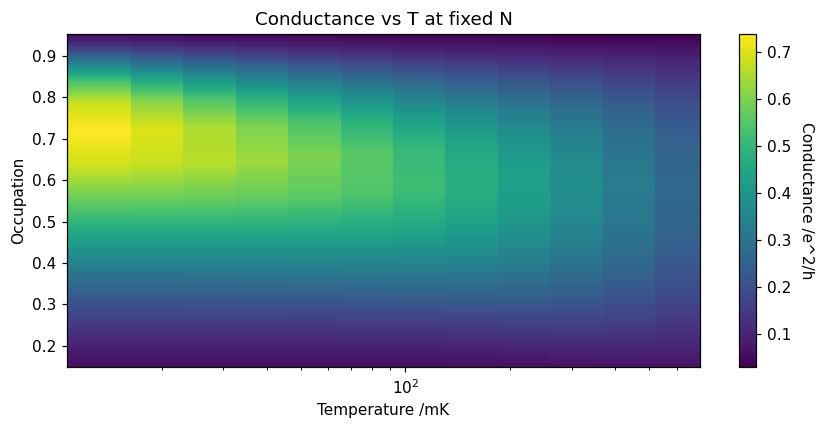

In [31]:
 
fixed_Ns_2d = np.linspace(0.15, 0.95, 200)

fig2, ax2 = plt.subplots(1, figsize=(8,4))
ax2.set_title(f'Conductance vs T at fixed N')
ax2.set_xlabel('Temperature /mK')
ax2.set_ylabel('Occupation')

cond_vs_T_2d = []
for i, n in enumerate(fixed_Ns_2d):
    cond_vs_T_2d.append(get_cond_vs_T(occ, cond, n))
cond_vs_T_2d = np.array(cond_vs_T_2d)
pcm = ax2.pcolormesh(ts*1000/(fixed_g*0.001), fixed_Ns_2d, cond_vs_T_2d, shading='nearest')
cbar = fig2.colorbar(pcm, ax=ax2)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Conductance /e^2/h', rotation=270)
ax2.set_xscale('log')
fig2.tight_layout()

fig.savefig(fig_dir+'conductance_vs_t_fixed_n.png')
fig2.savefig(fig_dir+'conductance_vs_t_fixed_n_2d.png')

### Fitting Conductance vs N data
We should be able to fit to this data using Eq. 2 from DGG. That's what we'll do next.

In [32]:
def kondo_conductance_fixed_e0(x, Tk, G0, s):
    """
    Conductance as a function of T (here 'x') for fixed epsilon_0 (fixed N?)
    G(T_K) = G_0/2
    
    From DGG 1998 paper"""
    tk_prime = Tk/np.sqrt(2**(1/s)-1)
    return G0*(tk_prime**2/(x**2+tk_prime**2))**s

# fig, ax = plt.subplots(1)
# g0 = 1
# x = np.linspace(0.01, 10, 200)
# s = 0.22

# for tk in np.linspace(0.1, 2, 10):
#     data = kondo_conductance_fixed_e0(x, tk, g0, s)
#     ax.plot(x, data, label=f'{tk:.3g}')
    
# ax.legend()
# ax.set_xscale('log')
# fig.tight_layout()

<span style="color:red">
    Question: In DGG paper it says this is for fixed $\epsilon_0$. Is it sufficient to used fixed $N$ instead? Is fixed $N$ actually desireable, and the fixed $\epsilon_0$ statement is only because they can't measure $N$?
</span>    

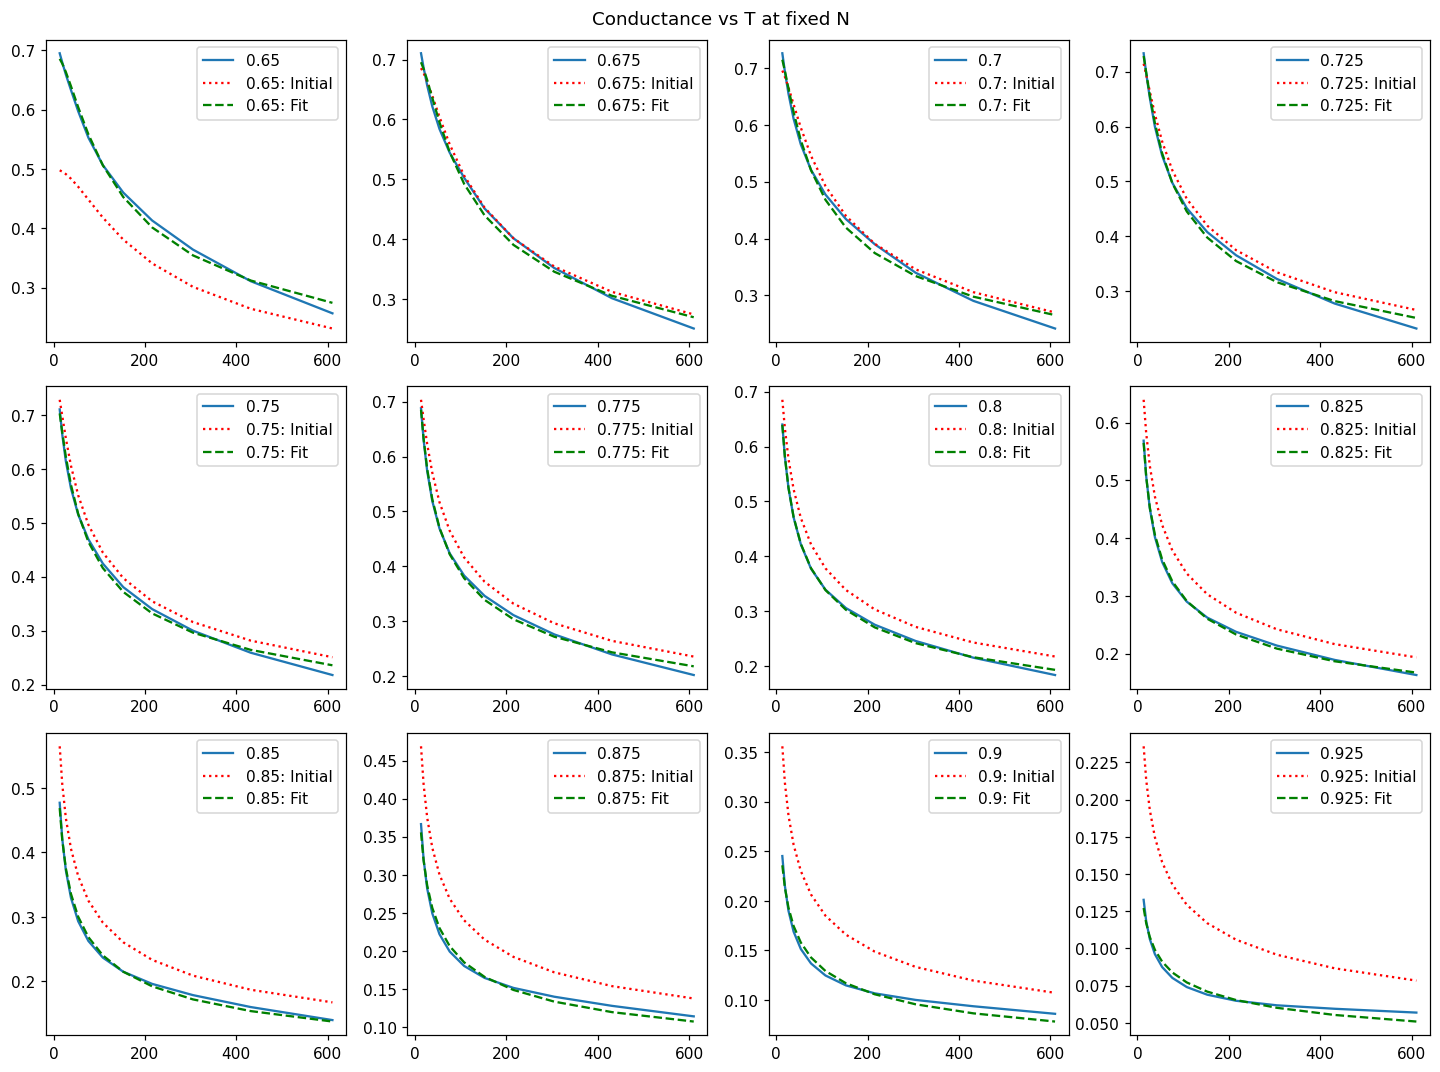

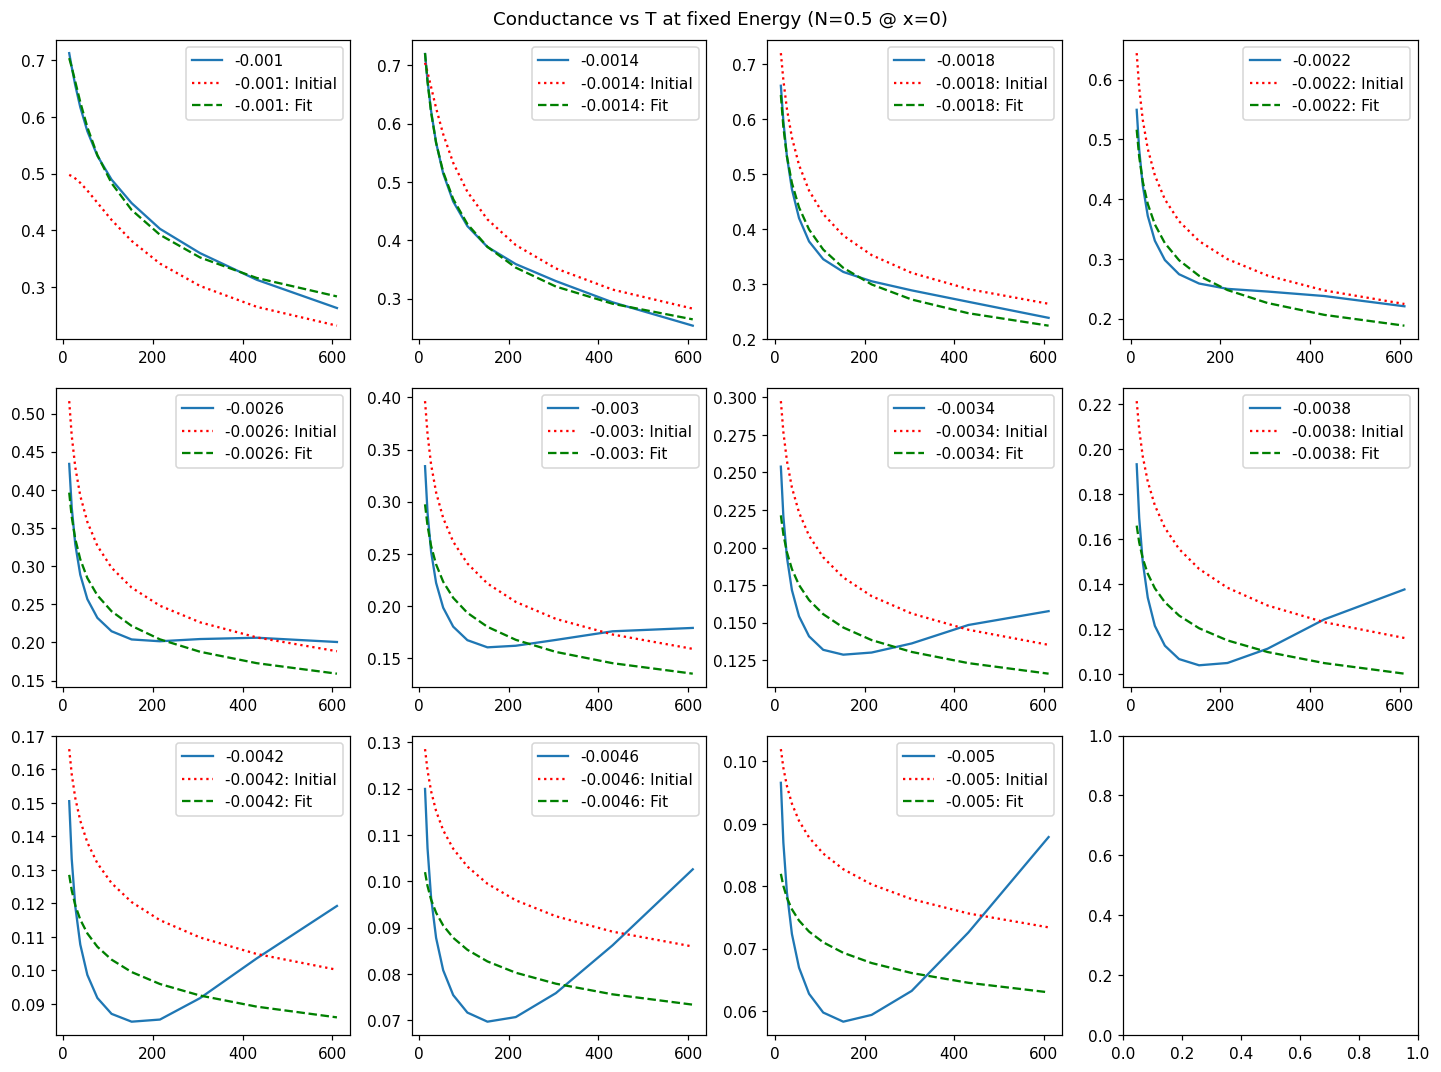

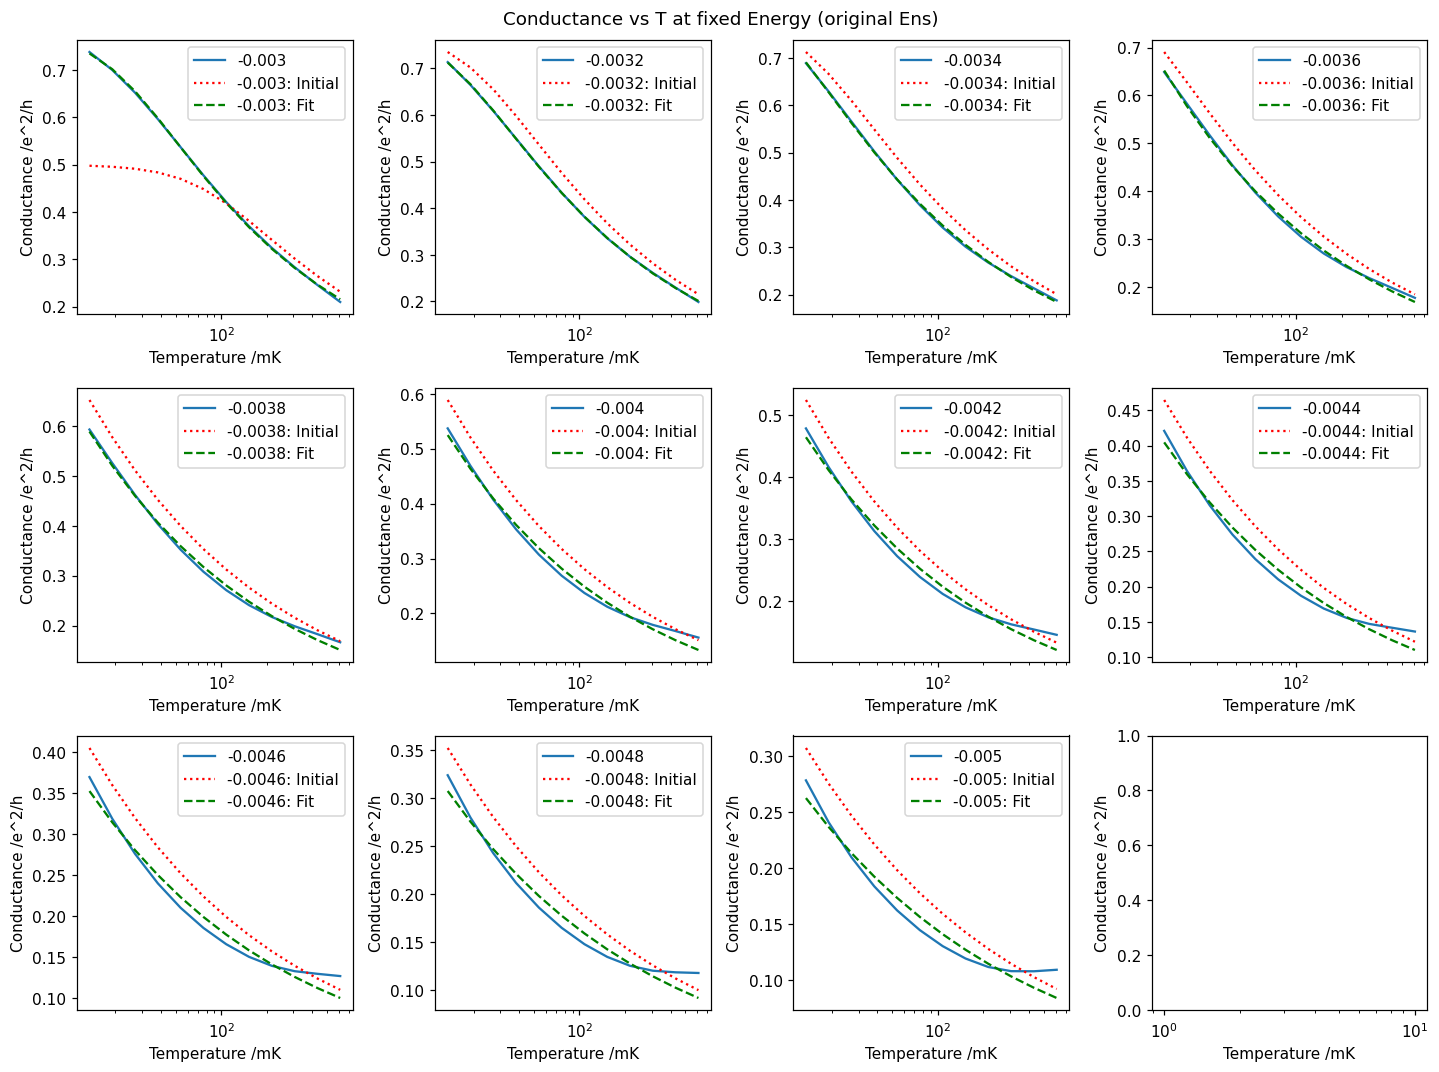

In [37]:
# fixed_Ns = np.arange(0.45, 0.85, 0.025)
# fixed_centered_ens = np.linspace(-0.001, -0.004, 11)
# fixed_ens = np.linspace(-0.0025, -0.004, 11)
# all_fixed_values = [fixed_Ns, fixed_centered_ens, fixed_ens]
all_fixed_values = [fixed_Ns_right, fixed_centered_ens_right, fixed_ens_right]
x_axes = [occ, x_ns, nrg_ens]

all_axs = [] 
figs = []
for values in all_fixed_values:
    fig, axs = make_axes(len(values))
    figs.append(fig)
    all_axs.append(axs)
figs[0].suptitle('Conductance vs T at fixed N')
figs[1].suptitle('Conductance vs T at fixed Energy (N=0.5 @ x=0)')
figs[2].suptitle('Conductance vs T at fixed Energy (original Ens)')
for ax in [ax for ax in axs for axs in all_axs]:
    ax.set_xlabel('Temperature /mK')
    ax.set_ylabel('Conductance /e^2/h')
    ax.set_xscale('log')

    
model = lm.models.Model(kondo_conductance_fixed_e0)
all_fits = []
all_cond_vs_ts = []
for j, values in enumerate(all_fixed_values):
    axs = all_axs[j]
    x_axis = x_axes[j]
    params = lm.Parameters()
    params.add_many(
        lm.Parameter('Tk', 500, True, 0.05, 2000),
        lm.Parameter('G0', 0.5, True, 0.1, 1),
        lm.Parameter('s', 0.2, True, 0.05, 0.3),
    )

    T = ts*1000/(fixed_g*0.001)
    fits = []
    cond_vs_Ts = []
    for i, value in enumerate(values):
        ax = axs[i]
        cond_vs_T = get_cond_vs_T(x_axis, cond, value)
        cond_vs_Ts.append(cond_vs_T)
        ax.plot(T, cond_vs_T, label=f'{value:.3g}') # , marker='x')
        fit = model.fit(cond_vs_T, x=T, params=params)
        fits.append(fit)
        params = copy.copy(fit.params) # use these params for next fit
        for par in params.values():
            par.max = par.value*5
            par.min = par.value*0.2
        ax.plot(T, fit.init_fit, label=f'{value:.3g}: Initial', color='r', linestyle=':')
        ax.plot(T, fit.best_fit, label=f'{value:.3g}: Fit', color='g', linestyle='--')
        ax.legend()
        
    all_fits.append(fits)
    all_cond_vs_ts.append(cond_vs_Ts)

for fig in figs:
    fig.tight_layout()

Check that fitting is working OK.
Definitely have to be somewhat careful with fitting parameters here. Works well on the more occupied side near the peak conductance, starts to struggle further from that. 
To improve fitting outcomes, I set upper and lower limits on fit parameters based on the previous fit. So, assuming you have good enough starting parameters for the first fit, the rest should work reasonably well.

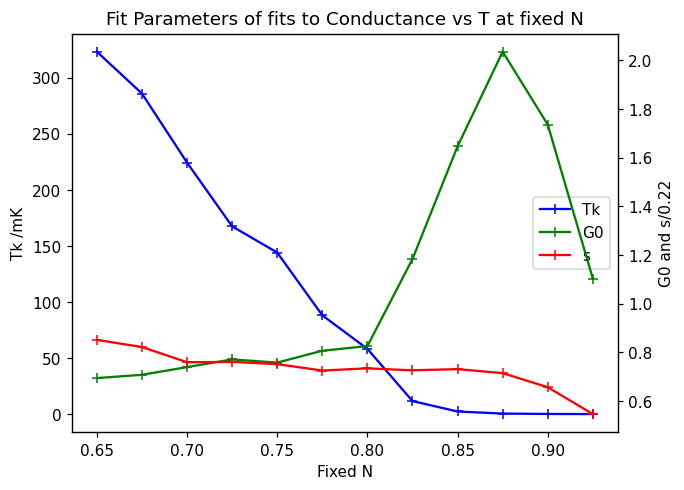

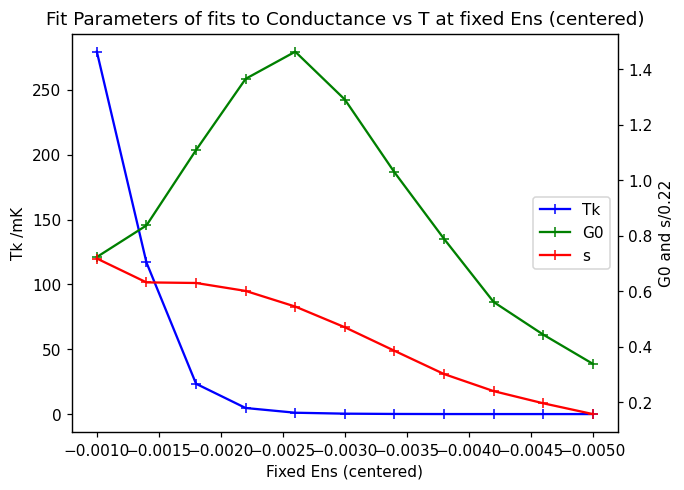

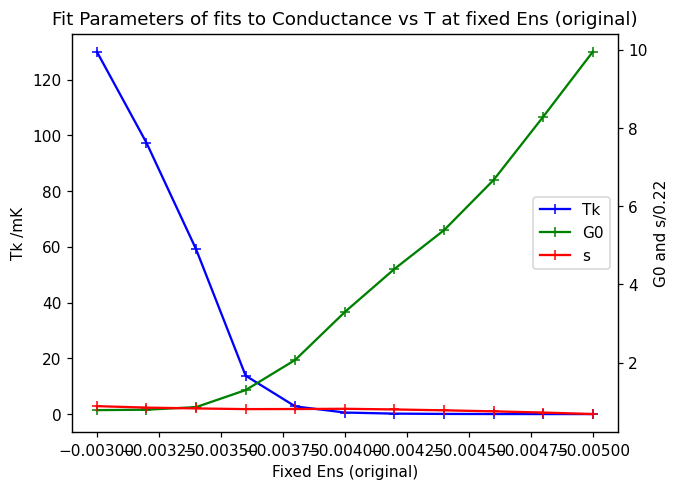

In [38]:
fixed_labels = ['N', 'Ens (centered)', 'Ens (original)']
figs = []
axs = []
for i, label in enumerate(fixed_labels):
    fixed_values = all_fixed_values[i]
    fits = all_fits[i]
    fig, ax = plt.subplots(1)
    tks = [fit.best_values['Tk'] for fit in fits]
    g0s = [fit.best_values['G0'] for fit in fits]
    ss = np.array([fit.best_values['s'] for fit in fits])
    ax.plot(fixed_values, tks, color='b', marker='+', label='Tk')

    axtwin = ax.twinx()
    axtwin.plot(fixed_values, g0s, color='g', marker='+')
    axtwin.plot(fixed_values, ss/0.22, color='r', marker='+')
    ax.plot([], [], color='g', marker='+', label='G0')
    ax.plot([], [], color='r', marker='+', label='s')
    ax.legend(loc='center right')

    ax.set_xlabel(f'Fixed {label}')
    ax.set_ylabel('Tk /mK')
    ax.set_title(f'Fit Parameters of fits to Conductance vs T at fixed {label}')
    axtwin.set_ylabel('G0 and s/0.22')
    axs.append(ax)
    
for ax in axs[1:]:
    ax.invert_xaxis()

for fig in figs:
    figs.append(fig)
    fig.savefig(fig_dir+f'fit_params_conductance_vs_t_various_{label}.png')


Fit parameters for the fits in the preceding figure.
Note: The fits that generated these fit parameters may not be trustworthy (check the fits)

Expectation is that in the unitary limit ($N \rightarrow 1$), the value of $s$ is constant and $s = 0.22$. In the mixed-valence regime, $N \sim 0.5$, $s$ is expected to vary.

Additionally, $T_K$ is expected to rise in the mixed-valence regime, which we do see.
As for $G_0$, I'm not sure what the expectation is for this. 

<span style="color:red">
    Question: Is $G_0$ here supposed to vary according to (DGG):
</span>

$$
G_0(n_d) = G_{max}\sin^2\left(\frac{\pi}{2}n_d\right)
$$
where, $G_{max}$ is $2e^2/h$ if the barriers are symmetric, less otherwise.
If so, it's not obvious that we are seeing that. But then our NRG data is only simulated with a single lead, so I'm not sure how that would play into things either.

Now we should be able to use the $G_0$ and $T_K$ for each fixed $N$ to rescale the conductance and temperature using $\tilde{G}_0(\tilde T) \equiv G(T/T_K)/G_0$. The normalized conductance, $\tilde G(\tilde T)$ is expected to be universal in the unitary limit. I.e. all Conductance vs $T$ at fixed $N$ should collapse on top of each other. Into the mixed-valence regime the conductance is expected to have a sharper crossover at $T = T_K$.

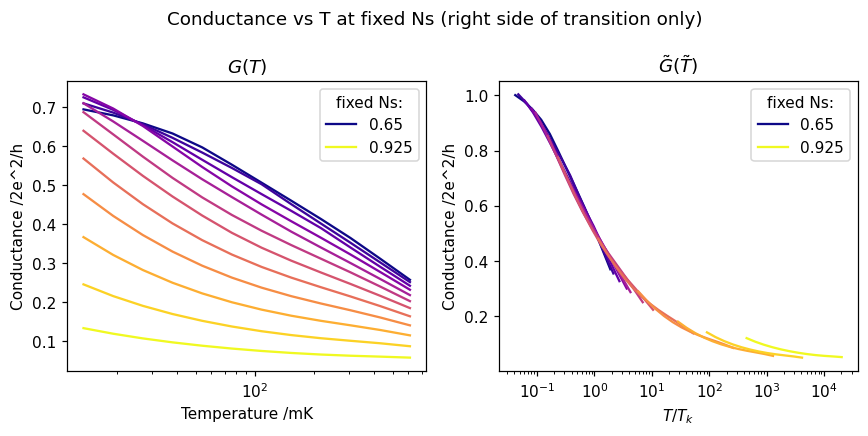

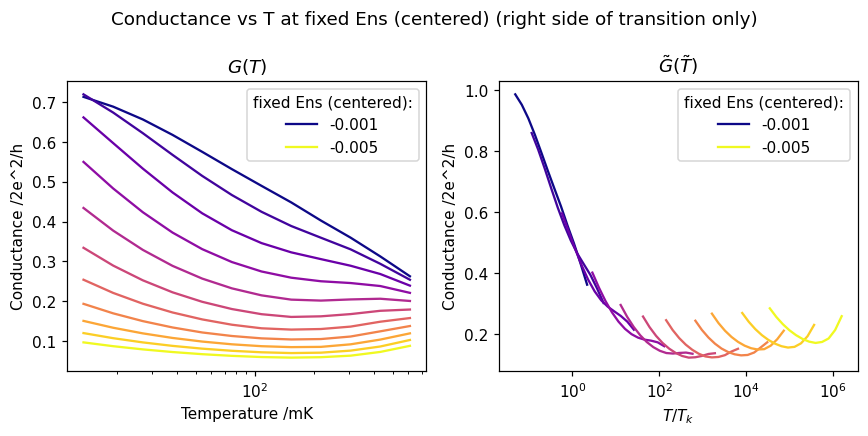

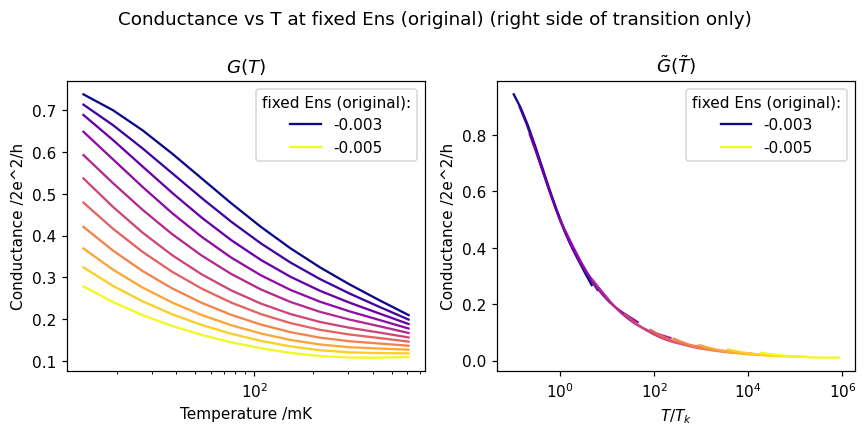

In [41]:
titles = ['fixed Ns', 'fixed Ens (centered)', 'fixed Ens (original)']
for i, title in enumerate(titles):
    fixed_values = all_fixed_values[i]
    fits = all_fits[i]
    cond_vs_Ts = all_cond_vs_ts[i]

    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    fig.suptitle(f'Conductance vs T at {title} (right side of transition only)')
    axs[0].set_title(f'$G(T)$')
    axs[1].set_title(r'$\tildeG(\tilde{T})$')

    for ax in axs:
        ax.set_ylabel('Conductance /2e^2/h')
        ax.set_xscale('log')

    axs[0].set_xlabel('Temperature /mK')
    axs[1].set_xlabel('$T/T_k$')

    colors = plt.cm.plasma(np.linspace(0,1,len(fits)))
    for j, (cond_vs_T, fit, val)  in enumerate(zip(cond_vs_Ts, fits, fixed_values)):
        leg_prefix = '' if j == 0 or j == len(fits)-1 else '_'  # Only show first and last in legend
        axs[0].plot(ts*1000/(fixed_g*0.001), cond_vs_T, color=colors[j], label=f'{leg_prefix}{val:.3g}') # , marker='x')
        axs[1].plot(ts*1000/(fixed_g*0.001)/fit.best_values['Tk'], cond_vs_T/fit.best_values['G0'], color=colors[j] , label=f'{leg_prefix}{val:.3g}') # , marker='x')

    for ax in axs:
        ax.legend(title=f'{title}:')
    fig.tight_layout()
    fig.savefig(fig_dir+f'collapsed_conductance_vs_T_{title}.png')
    

Looks like this worked quite well for fixed N and the original NRG ens axis, but not the centered energy axis.
On the right-hand side we see that the higher $N$ curves collapse on top of each other, and the mixed-valence regime data has a steeper transition around $T=T_K$.


C:\Users\Child\AppData\Local\Temp\ipykernel_26560\1733554380.py:2: RuntimeWarning:

divide by zero encountered in true_divide



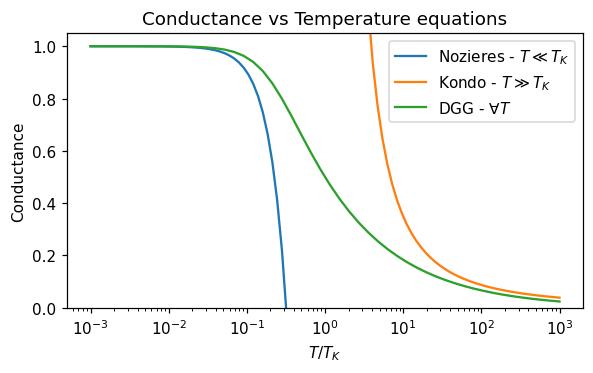

In [19]:
def high_T_conductance(x, Tk, G0):
    return G0*((3*np.pi**2/16)/(np.log(x/Tk)**2))

def unitary_conductance(x, Tk, G0):
    return G0*(1-((np.pi*x)/(Tk))**2)

def dgg_conductance(x, Tk, G0, s=0.22):
    """
    Conductance as a function of T (here 'x') for fixed epsilon_0 (fixed N?)
    G(T_K) = G_0/2
    
    From DGG 1998 paper"""
    tk_prime = Tk/np.sqrt(2**(1/s)-1)
    return G0*(tk_prime**2/(x**2+tk_prime**2))**s


fig, ax = plt.subplots(1, figsize=(5.5,3.5))
low_ts = np.logspace(np.log10(0.001), np.log10(1))
high_ts = np.logspace(np.log10(1), np.log10(1000))
all_ts = np.logspace(np.log10(0.001), np.log10(1000))

for ts, fn, label in zip([low_ts, high_ts, all_ts],
                  [unitary_conductance, high_T_conductance, dgg_conductance],
                  [r'Nozieres - $T\ll T_K$', r'Kondo - $T\gg T_K$', r'DGG - $\forall T$'],
                 ):
    data = fn(ts, 1, 1)
    ax.plot(ts, data, label=label)

ax.legend()
ax.set_xlabel('$T/T_K$')
ax.set_ylabel('Conductance')
ax.set_xscale('log')
ax.set_title('Conductance vs Temperature equations')
ax.set_ylim(0, 1.05)
fig.tight_layout()

In [ ]:
fig.savefig(fig_dir+'conductance_equations.png')


Unfinished stuff below here. 

Unfinished stuff below here. 

(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

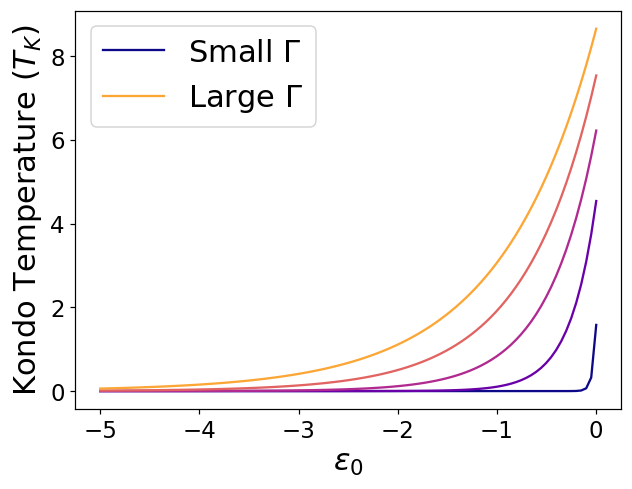

In [51]:
def kondo_T(e_0, gamma, U):
    return np.sqrt(gamma*U)/2*np.exp(np.pi*e_0*(e_0+U)/(gamma*U))

def e_to_N(e_0, gamma):
    nrg_data = nrg.NRGData.from_mat()
    pass

U = 100  # Infinite in NRG calculations
x = np.linspace(-5, 0, 100)

fig, ax = plt.subplots(1)
colors = plt.cm.plasma(np.linspace(0, 0.8, 5))
for gamma, c in zip(np.linspace(0.1, 3, len(colors)), colors):
    ax.plot(x, kondo_T(x, gamma, U), color=c)

ax.plot([],[],color=colors[0], label='Small $\Gamma$')
ax.plot([],[],color=colors[-1], label='Large $\Gamma$')
ax.set_xlabel('$\epsilon_0$', fontdict=dict(size=20))
ax.set_ylabel(r'Kondo Temperature $(T_K)$', fontdict=dict(size=20))
ax.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# ax.set_xlabel('Dot Occupation (N)', fontdict=dict(size=20))

# fig.savefig(fig_dir+'kondo_temp.png')